## Notebook do projeto final Semantix ##

In [2]:
import wget


## Download de dados do link fornecido

url = "https://mobileapps.saude.gov.br/esus-vepi/files/unAFkcaNDeXajurGB7LChj8SgQYS2ptm/04bd3419b22b9cc5c6efac2c6528100d_HIST_PAINEL_COVIDBR_06jul2021.rar"

dados = wget.download(url, "dados.rar")



In [6]:
##transferir do linux local para dentro do container namenode

!docker cp 2020_01.csv namenode:/
!docker cp 2020_02.csv namenode:/
!docker cp 2021_01.csv namenode:/
!docker cp 2021_02.csv namenode:/

    

/bin/sh: 1: docker: not found
/bin/sh: 1: docker: not found
/bin/sh: 1: docker: not found
/bin/sh: 1: docker: not found


In [10]:
### Transferir dados do namenode para a pasta do HDFS

!hdfs dfs -put 2020_01.csv /user/matheus/projetoS
!hdfs dfs -put 2020_02.csv /user/matheus/projetoS
!hdfs dfs -put 2021_01.csv /user/matheus/projetoS
!hdfs dfs -put 2021_02.csv /user/matheus/projetoS



put: `2020_01.csv': No such file or directory
put: `2020_02.csv': No such file or directory
put: `2021_01.csv': No such file or directory
put: `2021_02.csv': No such file or directory
ls: `.': No such file or directory


In [128]:
### Check de dados no HDFS
!hdfs dfs -ls /user/matheus/projetoS/

Found 4 items
-rw-r--r--   3 root supergroup   62492959 2021-07-18 14:09 /user/matheus/projetoS/2020_01.csv
-rw-r--r--   3 root supergroup   76520681 2021-07-18 14:10 /user/matheus/projetoS/2020_02.csv
-rw-r--r--   3 root supergroup   91120916 2021-07-18 14:10 /user/matheus/projetoS/2021_01.csv
-rw-r--r--   3 root supergroup    3046774 2021-07-18 14:10 /user/matheus/projetoS/2021_02.csv


In [12]:
### identificar estrutura dos dados .csv

!hdfs dfs -cat /user/matheus/projetoS/2020_01.csv | head











cat: Unable to write to output stream.


In [7]:
### Criação da Database

spark.sql("create database projeto_semantix")
spark.sql("show databases").show()


+----------------+
|    databaseName|
+----------------+
|         default|
|projeto_semantix|
+----------------+



In [15]:
! hdfs dfs -ls /user/hive/warehouse

Found 6 items
drwxr-xr-x   - root supergroup          0 2021-07-20 00:38 /user/hive/warehouse/teste
drwxr-xr-x   - root supergroup          0 2021-07-20 01:25 /user/hive/warehouse/teste2
drwxr-xr-x   - root supergroup          0 2021-07-20 01:32 /user/hive/warehouse/teste5
drwxr-xr-x   - root supergroup          0 2021-07-20 01:37 /user/hive/warehouse/teste88
drwxr-xr-x   - root supergroup          0 2021-07-20 02:39 /user/hive/warehouse/view1
drwxr-xr-x   - root supergroup          0 2021-07-20 02:46 /user/hive/warehouse/view2


In [59]:
### Carga de dados .csv na tabela criada dados_covid


### nao é mais necessario para esse script, load feito direto via criação da external table
!load data inpath '/user/matheus/projetoS' into table dados_covid;

/bin/sh: 1: load: not found


In [1]:
### atribui a table dados covid a variavel tabela
tabela = spark.read.table("dados_covid")
tabela.printSchema()

root
 |-- regiao: string (nullable = true)
 |-- estado: string (nullable = true)
 |-- municipio: string (nullable = true)
 |-- cod_uf: integer (nullable = true)
 |-- cod_mun: integer (nullable = true)
 |-- cod_regiao_saude: integer (nullable = true)
 |-- nome_regiao_saude: string (nullable = true)
 |-- data: date (nullable = true)
 |-- semana_epi: integer (nullable = true)
 |-- populacaotcu2019: integer (nullable = true)
 |-- casos_acumulados: integer (nullable = true)
 |-- casos_novos: integer (nullable = true)
 |-- obitos_acumulado: integer (nullable = true)
 |-- obitos_novos: integer (nullable = true)
 |-- recuperados_novos: integer (nullable = true)
 |-- em_acompanhamento_novos: integer (nullable = true)
 |-- interior_metropolitana: string (nullable = true)



In [8]:
### Criação das querys

total_casos_recuperados = spark.sql("select MAX (recuperados_novos) as Casos_Recuperados from dados_covid").show()
casos_em_acompanhamento = spark.sql("select LAST (em_acompanhamento_novos) as Em_Acompanhamento from dados_covid WHERE em_acompanhamento_novos IS NOT NULL").show()

total_casos_acumulados = spark.sql("select MAX (casos_acumulados) as Acumulado from dados_covid ").show()
casos_novos = spark.sql("select MAX (casos_novos) as Casos_novos from dados_covid where data = ('2021-07-06')").show()
incidencia = spark.sql("SELECT ROUND(((MAX(casos_acumulados) / MAX(populacaotcu2019))*100000),1) as incidencia from dados_covid where data = ('2021-07-06')").show()

###Calculo incidencia (casos confirmados * 1.000.000) / população.
###Calculo letalidade (mortes totais/casos totais)
###Calculo mortalidade (mortes totais/população)

total_obitos_acumulados = spark.sql("select MAX (obitos_acumulado) as Obito_acumulado from dados_covid ").show()
obitos_novos = spark.sql("select MAX (obitos_novos) as Obitos_novos from dados_covid where data = ('2021-07-06')").show()
letalidade = spark.sql("SELECT ROUND(((MAX(obitos_acumulado) / MAX(casos_acumulados))*100),1) as letalidade from dados_covid").show()
mortalidade = spark.sql("SELECT ROUND(((MAX(obitos_acumulado) / MAX(populacaotcu2019))*100000),1) as mortalidade from dados_covid").show()


#populacao = spark.sql("select MAX (populacaotcu2019) as populacao from dados_covid where data = ('2021-07-06')").show()

+-----------------+
|Casos_Recuperados|
+-----------------+
|         17262646|
+-----------------+

+-----------------+
|Em_Acompanhamento|
+-----------------+
|          1065477|
+-----------------+

+---------+
|Acumulado|
+---------+
| 18855015|
+---------+

+-----------+
|Casos_novos|
+-----------+
|      62504|
+-----------+

+----------+
|incidencia|
+----------+
|    8972.3|
+----------+

+---------------+
|Obito_acumulado|
+---------------+
|         526892|
+---------------+

+------------+
|Obitos_novos|
+------------+
|        1780|
+------------+

+----------+
|letalidade|
+----------+
|       2.8|
+----------+

+-----------+
|mortalidade|
+-----------+
|      250.7|
+-----------+



In [29]:
### Criação das views


total_casos_recuperados = spark.sql("ALTER VIEW Casos_Recuperados AS select 'Casos_Recuperados', MAX (recuperados_novos) as total_casos_recuperados from dados_covid UNION select 'Em_acompanhamento', MAX (em_acompanhamento_novos) as Em_Acompanhamento from dados_covid WHERE data = ('2021-07-06')").show()

casos_confirmados = spark.sql("ALTER VIEW Casos_confirmados AS select 'Acumulados', (MAX (casos_acumulados)) as casos_confirmados from dados_covid UNION select 'Casos_novos', MAX (casos_novos) as Casos_novos from dados_covid where data = ('2021-07-06') UNION SELECT 'Incidencia', ROUND(((MAX(casos_acumulados) / MAX(populacaotcu2019))*100000),1) as incidencia from dados_covid where data = ('2021-07-06')").show()

Obitos_confirmados = spark.sql("ALTER VIEW Obitos_confirmados AS select 'Total_obitos', MAX (obitos_acumulado) as Obitos_confirmados from dados_covid UNION select 'obitos_novos', MAX (obitos_novos) as Obitos_novos from dados_covid where data = ('2021-07-06') UNION SELECT 'obitos_acumulado', ROUND(((MAX(obitos_acumulado) / MAX(casos_acumulados))*100),1) as letalidade from dados_covid UNION SELECT 'mortalidade', ROUND(((MAX(obitos_acumulado) / MAX(populacaotcu2019))*100000),1) as mortalidade from dados_covid").show()




++
||
++
++

++
||
++
++

++
||
++
++



In [30]:
### Verificar as view

spark.sql("SELECT * from Casos_Recuperados").show()
spark.sql("SELECT * from Casos_confirmados").show()
spark.sql("SELECT * from Obitos_confirmados").show()




+-----------------+-----------------------+
|casos_recuperados|total_casos_recuperados|
+-----------------+-----------------------+
|Em_acompanhamento|                1065477|
|Casos_Recuperados|               17262646|
+-----------------+-----------------------+

+-----------+-----------------+
| acumulados|casos_confirmados|
+-----------+-----------------+
| Acumulados|      1.8855015E7|
| Incidencia|           8972.3|
|Casos_novos|          62504.0|
+-----------+-----------------+

+----------------+------------------+
|    total_obitos|obitos_confirmados|
+----------------+------------------+
|    Total_obitos|          526892.0|
|    obitos_novos|            1780.0|
|obitos_acumulado|               2.8|
|     mortalidade|             250.7|
+----------------+------------------+



In [4]:
### Criar a view 1 como tabela hive

View1 = spark.sql("SELECT * from Casos_Recuperados")
View1.write.saveAsTable("View1")

In [1]:
### Visualizar tabela hive

spark.sql("SELECT * from View1").show()


+---+-----------------------+
|  1|total_casos_recuperados|
+---+-----------------------+
|  2|                1065477|
|  1|               17262646|
+---+-----------------------+



In [12]:
### Verificar warehouse 

!hdfs dfs -ls /user/hive/warehouse/view1

Found 4 items
-rw-r--r--   2 root supergroup          0 2021-07-20 02:39 /user/hive/warehouse/view1/_SUCCESS
-rw-r--r--   2 root supergroup        380 2021-07-20 02:39 /user/hive/warehouse/view1/part-00000-9a260e62-934b-4952-9161-4ad6a143ccbb-c000.snappy.parquet
-rw-r--r--   2 root supergroup        643 2021-07-20 02:39 /user/hive/warehouse/view1/part-00027-9a260e62-934b-4952-9161-4ad6a143ccbb-c000.snappy.parquet
-rw-r--r--   2 root supergroup        643 2021-07-20 02:39 /user/hive/warehouse/view1/part-00145-9a260e62-934b-4952-9161-4ad6a143ccbb-c000.snappy.parquet


In [11]:
### Criar a view 2 com formato parquet e compressão snappy

View2 = spark.sql("SELECT * from Casos_confirmados")
View2.write.option("compression","snappy").parquet('/user/hive/warehouse/view2')

In [7]:
### Visualizar tabela hive com a compressão 

spark.read.parquet("/user/hive/warehouse/view2").show()

+---+-----------------+
|  1|casos_confirmados|
+---+-----------------+
|  1|      1.8855015E7|
|  3|           8972.3|
|  2|          62504.0|
+---+-----------------+



In [14]:
### Verificar warehouse

!hdfs dfs -ls /user/hive/warehouse/view2

Found 5 items
-rw-r--r--   2 root supergroup          0 2021-07-20 02:46 /user/hive/warehouse/view2/_SUCCESS
-rw-r--r--   2 root supergroup        367 2021-07-20 02:46 /user/hive/warehouse/view2/part-00000-1ee13c96-f1b9-4b8c-867b-360edade7c1d-c000.snappy.parquet
-rw-r--r--   2 root supergroup        662 2021-07-20 02:46 /user/hive/warehouse/view2/part-00045-1ee13c96-f1b9-4b8c-867b-360edade7c1d-c000.snappy.parquet
-rw-r--r--   2 root supergroup        662 2021-07-20 02:46 /user/hive/warehouse/view2/part-00112-1ee13c96-f1b9-4b8c-867b-360edade7c1d-c000.snappy.parquet
-rw-r--r--   2 root supergroup        662 2021-07-20 02:46 /user/hive/warehouse/view2/part-00142-1ee13c96-f1b9-4b8c-867b-360edade7c1d-c000.snappy.parquet


In [7]:
###Criar o envio dos dados para o kafka

from pyspark.sql.functions import *
from pyspark.sql.types import *

View3 = spark.sql("SELECT * from obitos_confirmados")




View3_converted = View3.withColumn("value", struct(col("total_obitos"),col("obitos_confirmados")))
View3_converted = View3_converted.drop("total_obitos","obitos_confirmados")
View3_converted = View3_converted.withColumn("value",col("value").cast("string"))
#View3_converted.toPandas()


View3_converted.write.format("kafka").option("kafka.bootstrap.servers", "kafka:9092").option("topic","view3").save()

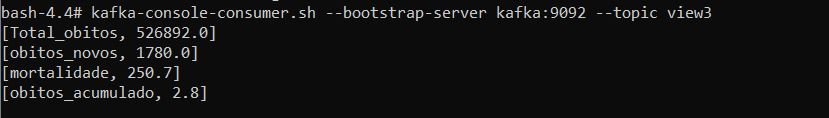

In [22]:
### Print abaixo do resultado de saida no console consumer do kafka 

from IPython.display import Image
Image('Kafka.JPG')

In [6]:
### Criação da view do exercicio 7 com spark Dataframe


from pyspark.sql.functions import col
from pyspark.sql.functions import lit

temp = tabela.select('regiao','populacaotcu2019','obitos_acumulado','casos_acumulados','estado').where(tabela.regiao != 'regiao')


temp = temp.groupBy('estado', 'regiao')
temp = temp.max('casos_acumulados','obitos_acumulado','populacaotcu2019')


temp = temp.groupBy('regiao')
temp = temp.sum('max(casos_acumulados)','max(obitos_acumulado)','max(populacaotcu2019)')
temp = temp.withColumn('mult', lit(100000))

temp = temp.withColumn('Incidencia', ((col('sum(max(casos_acumulados))') * col('mult'))/col('sum(max(populacaotcu2019))')))
temp = temp.withColumn('Mortalidade', ((col('sum(max(obitos_acumulado))')/col('sum(max(populacaotcu2019))'))) * col('mult'))

temp = temp.drop('mult','sum(max(populacaotcu2019))')
temp = temp.withColumnRenamed('sum(max(casos_acumulados))', 'Casos').withColumnRenamed('sum(max(obitos_acumulado))', 'Óbitos')
view7 = temp

view7.printSchema()
view7.toPandas()

root
 |-- regiao: string (nullable = true)
 |-- Casos: long (nullable = true)
 |-- Óbitos: long (nullable = true)
 |-- sum(max(obitos_novos)): long (nullable = true)
 |-- Incidencia: double (nullable = true)
 |-- Mortalidade: double (nullable = true)



,regiao,Casos,Óbitos,sum(max(obitos_novos)),Incidencia,Mortalidade
0,Nordeste,4455737,107824,5183,7807.268035,188.927414
1,Sul,3611041,80705,1859,12046.446916,269.232196
2,Sudeste,7138803,245311,2484,8078.179518,277.590836
3,Centro-Oeste,1916619,49207,707,11760.509893,301.937636
4,Brasil,18855015,526892,4249,8972.292626,250.725295
5,Norte,1732862,43845,630,9401.898326,237.887513


In [3]:
### Criação da view3 com spark Dataframe


from pyspark.sql.functions import col
from pyspark.sql.functions import lit

tabela = spark.read.table("dados_covid")
temp = tabela.select('regiao','populacaotcu2019','obitos_acumulado','casos_acumulados','estado').where(tabela.regiao == 'Brasil')


temp = temp.groupBy('estado', 'regiao')
temp = temp.max('casos_acumulados','obitos_acumulado','populacaotcu2019')


temp = temp.groupBy('regiao')
temp = temp.sum('max(casos_acumulados)','max(obitos_acumulado)','max(populacaotcu2019)')
temp = temp.withColumn('mult', lit(100000))
temp = temp.withColumn('mult2', lit(100))


temp = temp.withColumn('Mortalidade', ((col('sum(max(obitos_acumulado))')/col('sum(max(populacaotcu2019))'))) * col('mult'))
temp = temp.withColumn('Letalidade', ((col('sum(max(obitos_acumulado))')/col('sum(max(casos_acumulados))'))) * col('mult2'))
temp1 = tabela.select('obitos_novos','regiao').where(tabela.data == '2021-07-06')
temp1 = temp1.where(temp1.regiao == 'Brasil')



temp = temp.crossJoin(temp1)
temp = temp.drop('mult','sum(max(populacaotcu2019))','mult2','regiao','sum(max(casos_acumulados))')
temp = temp.withColumnRenamed('sum(max(obitos_acumulado))', 'Obitos Acumulados').withColumnRenamed('obitos_novos', 'Casos Novos')

'sum(max(obitos_acumulado))'

view7 = temp



view7.printSchema()
view7.toPandas()

root
 |-- Obitos Acumulados: long (nullable = true)
 |-- Mortalidade: double (nullable = true)
 |-- Letalidade: double (nullable = true)
 |-- Casos Novos: integer (nullable = true)



,Obitos Acumulados,Mortalidade,Letalidade,Casos Novos
0,526892,250.725295,2.79444,1780


In [8]:
### Conversão da view 3 em CSV para upload no elastic
view3_el = view7.write.format('csv').option("inferSchema", "true").option("header","true").save("/user/hive/warehouse/elastic_search/view3_elastic.csv")


In [9]:
###checagem de gravação
!hdfs dfs -ls /user/hive/warehouse/elastic_search/view3_elastic.csv

Found 3 items
-rw-r--r--   2 root supergroup          0 2021-08-02 00:41 /user/hive/warehouse/elastic_search/view3_elastic.csv/_SUCCESS
-rw-r--r--   2 root supergroup          0 2021-08-02 00:37 /user/hive/warehouse/elastic_search/view3_elastic.csv/part-00000-7742e91e-c299-48f5-b53f-337206b7347c-c000.csv
-rw-r--r--   2 root supergroup        102 2021-08-02 00:40 /user/hive/warehouse/elastic_search/view3_elastic.csv/part-00687-7742e91e-c299-48f5-b53f-337206b7347c-c000.csv


In [10]:
### checagem de gravação
spark.read.csv('/user/hive/warehouse/elastic_search/view3_elastic.csv', inferSchema = True, header = True).toPandas()

,Obitos Acumulados,Mortalidade,Letalidade,Casos Novos
0,526892,250.725295,2.79444,1780


In [ ]:
### Comandos Scala no terminal 

## Iniciar sessão com atributos abaixo

spark-shell --jars /opt/spark/jars/elasticsearch-spark_2.10-2.4.1.jar \
        --conf spark.es.nodes="YOUR-IP-ELASTICSEARCH" \
        --conf spark.es.port="9200" \
        --conf spark.es.index.auto.create=true \
        --conf spark.es.nodes.discovery=false

##Salvar view no Elastic

import org.elasticsearch.spark.sql._
val view3 = spark.read.option("inferSchema",true).option("header",true).csv("/user/hive/warehouse/elastic_search/view3_elastic.csv")
view3.show()
view3.saveToEs("view3_elastic")